# End of module project
PART 2 - Simple prediction model test

Objective is to try and have a simple odds prediction model

Uses the tennis matches results data between 2020 and 2022 from http://tennis-data.co.uk/alldata.php

In [1]:
# do the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# read enriched data file
df = pd.read_csv('./2020-2022-enriched.csv')
df.head()

,Unnamed: 0,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,...,PSW,PSL,MaxW,MaxL,AvgW,AvgL,W10lastW,W10lastL,W5lastW,W5lastL
0,0,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,...,2.21,1.74,2.25,1.80,2.11,1.72,0,0,0,0
1,1,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,...,1.60,2.47,1.65,2.47,1.59,2.34,0,0,0,0
2,2,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,...,1.31,3.74,1.33,3.85,1.29,3.53,0,0,0,0
3,3,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,...,1.97,1.92,2.00,2.07,1.87,1.92,0,0,0,0
4,4,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,...,1.54,2.62,1.57,2.65,1.53,2.47,0,0,0,0


In [2]:
# drop the lines where there are no data in AvgW, AvgL, WRank or LRank
numels = df.shape[0]
df = df.dropna(subset=['AvgW','AvgL','WRank','LRank'],axis=0)
print('Drop NA on AvgW, AvgL, WRank, LRank: ',numels-df.shape[0],' rows dropped')

# drop the lines where AvgW ou AvgL are dubious (more than 50% away from B365W / B365L)
numels = df.shape[0]
df = df.drop(df[df['AvgW']>1.5*df['B365W']].index,axis=0)
df = df.drop(df[df['AvgL']>1.5*df['B365L']].index,axis=0)
print('Drop dubious odds: ',numels-df.shape[0],' rows dropped')

df = df.reset_index(drop=True)

# compute delta rank (difference between winner and loser ranks)
df['DeltaRank'] = df['WRank']-df['LRank']

Drop NA on AvgW, AvgL, WRank, LRank:  0  rows dropped
Drop dubious odds:  10  rows dropped


Testing Linear Regression model based on rankings only (obviously too simple, but for the sake of trying)

In [12]:
# try and build model just based on rankings
subdf = df[['WRank','LRank','W10lastW','W10lastL','W5lastW','W5lastL','AvgW']]

# with LinearRegression
# r2 at 0.27 / 0.26 on train and test data
# select only matches where AvgW was <4 -> 0.32 / 0.33
# select only matches where AvgW was <3 -> 0.34 / 0.29
# select only matches where AvgW was <2 -> 0.27 / 0.27

# with RandomForestRegressor
# r2 at 0.64 / 0.43 on train and test data
# select only matches where AvgW was <4 -> 0.55 / 0.49
# select only matches where AvgW was <3 -> 0.55 / 0.46
# select only matches where AvgW was <2 -> 0.5 / 0.46
#subdf = subdf[subdf['AvgW']<4]

X = subdf[['WRank','LRank','W10lastW','W10lastL','W5lastW','W5lastL']]
y = subdf['AvgW']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=2)

#Instantiate
#lm_model = LinearRegression(normalize=True) 
lm_model = make_pipeline(StandardScaler(with_mean=False), RandomForestRegressor(max_depth=5, random_state=0)) # deprecation of Normalize=True
#lm_model = RandomForestRegressor(max_depth=5, random_state=0)


#Fit
lm_model.fit(X_train, y_train)

#Predict
y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train) 

"The r-squared score for the model was {} on train set and {} on test set.".format(r2_score(y_train, y_train_preds), r2_score(y_test, y_test_preds))



'The r-squared score for the model was 0.6359328101731712 on train set and 0.4298154870837374 on test set.'

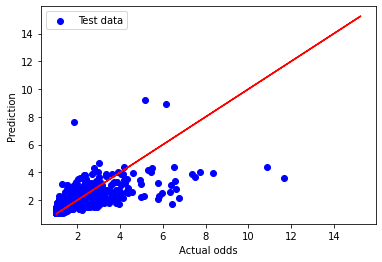

In [13]:
# show data
plt.scatter(y_test, y_test_preds, color = 'blue',label='Test data')
plt.plot(y_train, y_train, color = 'red')
plt.xlabel("Actual odds")
plt.ylabel("Prediction")
plt.legend()
plt.show()